In [1]:
# importing libraries
import ast
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda skill_list: ast.literal_eval(skill_list) if pd.notna(skill_list) else skill_list)

# Filter for Data Analyst data
df_DA = df[df['job_title_short'] == 'Data Analyst'].copy()

In [2]:
df_DA['job_posted_month_no'] = df_DA['job_posted_date'].dt.month

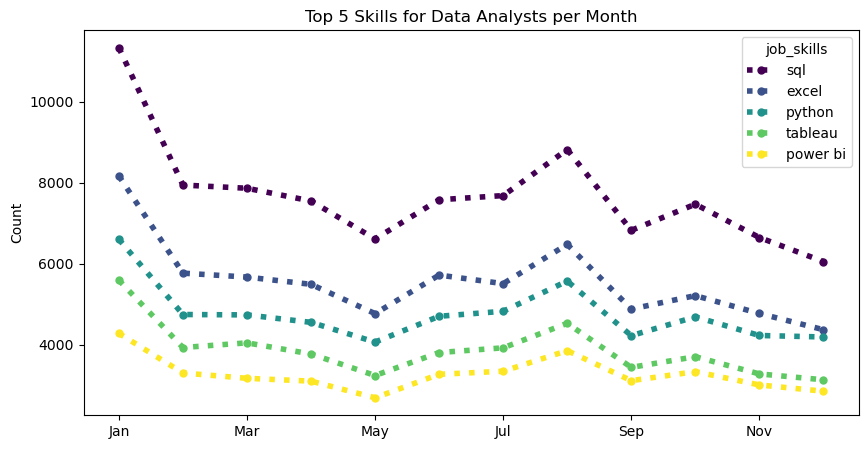

In [3]:
df_DA_explode = df_DA.explode('job_skills')

df_DA_pivot = df_DA_explode.pivot_table(index='job_posted_month_no', columns='job_skills', aggfunc='size', fill_value=0)

df_DA_pivot.loc['Total'] = df_DA_pivot.sum()
df_DA_pivot = df_DA_pivot[df_DA_pivot.loc['Total'].sort_values(ascending=False).index]
df_DA_pivot = df_DA_pivot.drop('Total')

df_DA_pivot = df_DA_pivot.reset_index()
df_DA_pivot['job_posted_month'] = df_DA_pivot['job_posted_month_no'].apply(lambda x: pd.to_datetime(x, format='%m').strftime('%b'))
df_DA_pivot = df_DA_pivot.set_index('job_posted_month')
df_DA_pivot = df_DA_pivot.drop(columns='job_posted_month_no')

df_DA_pivot.iloc[:, :5].plot(
    kind='line',
    linewidth=4,
    linestyle=':', # options: '-', '--', '-.', ':'
    colormap='viridis', # options: 'viridis', 'plasma', 'inferno', 'magma', 'cividis'
    marker='o', # options: 'o', 'x', '+', '*', 's', ',', '.', '1', '2', '3', '4', ...
    markersize=5,
    figsize=(10,5)
    )
plt.title('Top 5 Skills for Data Analysts per Month')
plt.ylabel('Count')
plt.xlabel('')
plt.show()

In [6]:
df_exploded = df.explode('job_skills')

skill_stats = df_exploded.groupby('job_skills').agg(
    skill_count=('job_skills', 'count'),
    median_salary=('salary_year_avg', 'median')
)

skill_count = 20
skills_stats = skill_stats.sort_values(by='skill_count', ascending=False).head(skill_count)
skills_stats

,skill_count,median_salary
job_skills,,
sql,384849,120000.0
python,380909,125000.0
aws,145381,135000.0
azure,132527,125000.0
r,130892,119550.0
tableau,127213,111175.0
excel,127018,92500.0
spark,114609,140000.0
power bi,98147,102000.0


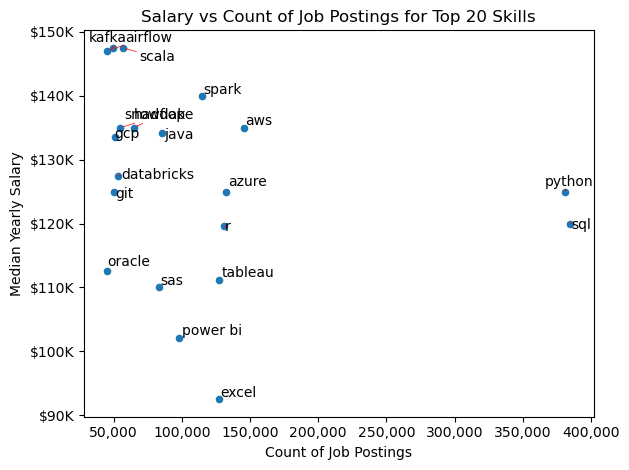

In [15]:
from adjustText import adjust_text

skills_stats.plot(kind='scatter', x='skill_count', y='median_salary')

texts = []
for i, txt in enumerate(skills_stats.index):
    texts.append(plt.text(skills_stats['skill_count'].iloc[i], skills_stats['median_salary'].iloc[i], txt))

adjust_text(texts, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))

ax = plt.gca()

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{int(x):,}'))

plt.xlabel('Count of Job Postings')
plt.ylabel('Median Yearly Salary')
plt.title(f'Salary vs Count of Job Postings for Top {skill_count} Skills')
plt.tight_layout()
plt.show()